# CoMPARA Predictions and Unrestricted Dataset Cross-Validation

In [ ]:
import os

import pandas as pd
import pickle

import ml
import utils
from analysis import CV, Predictions

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

In [3]:
pix_features = pd.read_csv("../AndroR_4_final_dataset_training_ALL_STD_rdkit_pix_descriptors 2.csv", index_col=0)
andror_df_all = pd.merge(andror_df_all, pix_features, on='flat_smiles', how='inner')
andror_df_all["final class"] = andror_df_all["final class_x"] # due to the merge command, some columns are duplicated and with a suffix

In [4]:
andror_df_pub = pd.read_csv("../AndroR_4_final_dataset_training_PUB_STD_rdkit.csv", index_col=0)

In [5]:
andror_df_all["unrestricted"] = andror_df_all["Compound No_x"].isin(andror_df_pub["Compound No"])

In [6]:
rdkit_descriptors = pd.read_csv("../rdkit_descriptors.csv")

In [7]:
andror_df_pub = andror_df_all[andror_df_all["unrestricted"]]
rdkit_descriptors_pub = rdkit_descriptors.loc[andror_df_all[andror_df_all["unrestricted"]].index]

In [8]:
fps = utils.get_fingerprints(andror_df_pub)

In [9]:
groups = utils.get_cluster_assignments_from_fps(fps, 0.65, chunk_size=5000)

# Train on Bayer HTS Data, Predict COMPARA

In [8]:
def fit_model_or_retrieve_from_disc(pipeline_filename: str):
    if os.path.exists(pipeline_filename):
        with open(pipeline_filename, 'rb') as f:
            fitted_pipeline = pickle.load(f)
    else:
        fitted_pipeline = ml.create_pipeline()
        sample_weights_unrestricted = ml.compute_sample_weights(andror_df_pub["final class"])
        fitted_pipeline.fit(
            X=rdkit_descriptors_pub, 
            y=andror_df_pub["final class"], 
            classifier__sample_weight=sample_weights_unrestricted,
        )

        with open(pipeline_filename, 'wb') as f:
            pickle.dump(fitted_pipeline, f)

    return fitted_pipeline

In [9]:
HTS_model_unrestricted = fit_model_or_retrieve_from_disc("pipelines_HTS_model_unrestricted.pkl")
HTS_model_full = fit_model_or_retrieve_from_disc("pipelines_HTS_model_full.pkl")

Generate RDKit descriptors for COMPARA Dataset

In [10]:
compara_dataset = pd.read_csv("../AR_binding_CoMPARA_raw_no_stereo_unique_SMILES.txt", sep="\t")

Find out how many entries are shared across our HTS dataset and CoMPARA

In [11]:
compara_dataset["SMILES_STD_FLAT"].isin(andror_df_all["flat_smiles"]).sum()

33

Remove all entries from CoMPARA Dataset which are already in our internal HTS set

In [12]:
compara_dataset = compara_dataset[~compara_dataset["SMILES_STD_FLAT"].isin(andror_df_all["flat_smiles"])]

In [13]:
rdkit_descriptors_compara = utils.get_rdkit_descriptors(compara_dataset, "SMILES_STD_FLAT")

Calculating RDKit descriptors: 100%|██████████| 1654/1654 [00:34<00:00, 48.62it/s]


There is one row where entries are missing:

In [14]:
missing_columns = rdkit_descriptors_compara.columns[rdkit_descriptors_compara.isnull().any()].tolist()
missing_columns

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [15]:
missing_rows = rdkit_descriptors_compara[rdkit_descriptors_compara.isnull().any(axis=1)]
len(missing_rows)

1

Just drop this single molecule

In [16]:
rdkit_descriptors_compara = rdkit_descriptors_compara.dropna()

In [17]:
compara_dataset = compara_dataset.loc[rdkit_descriptors_compara.index]

## Predictions for COMPARA

In [18]:
compara_predictions_trained_on_unrestricted = HTS_model_unrestricted.predict_proba(
    X=rdkit_descriptors_compara,
)

In [19]:
PREDICTIONS_compara_trained_on_unrestricted = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_unrestricted,
    )

In [20]:
CV_compara_trained_on_unrestricted = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_unrestricted,}
])

In [21]:
compara_predictions_trained_on_full = HTS_model_full.predict_proba(
    X=rdkit_descriptors_compara
)

In [22]:
PREDICTIONS_compara_trained_on_full = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_full[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_full,
    )

In [23]:
CV_compara_trained_on_full = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_full[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_full,}
])

In [25]:
CV_compara_trained_on_unrestricted.folds[0].find_npv_halving_tnr()

{'NPV': 0.9434361766485179, 'TNR': 0.8076398362892224}

In [26]:
CV_compara_trained_on_full.folds[0].find_npv_halving_tnr()

{'NPV': 0.9434361766485179, 'TNR': 0.7394270122783083}

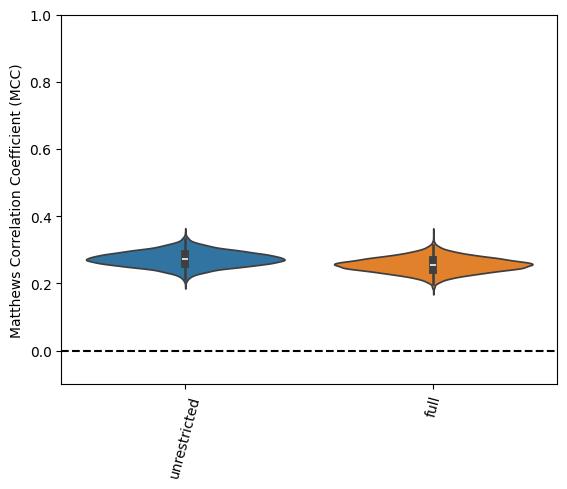

In [75]:
comparison_df = {}

label_threshold = 0.5
sel_metric = "MCC"
sample_size_posterior = 10000
prior = 1

data_dict = {
    "unrestricted": CV_compara_trained_on_unrestricted,
    "full": CV_compara_trained_on_full,
}

for feature_list, cv in data_dict.items():
    metric_estimates = []
    for fold in cv.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        metric_estimates += list(curr_samples)
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df)

sns.violinplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == "MCC":
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == "balanced accuracy":
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")
elif sel_metric == "NPV":
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"Negative Predictive Value (NPV)")
elif sel_metric == "PPV":
    plt.ylabel(f"Positive Predictive Value (PPV)")
elif sel_metric == "TPR":
    plt.ylabel(f"True Positive Rate (TPR)")
elif sel_metric == "TNR":
    plt.ylim(0.4, 1.0)
    plt.ylabel(f"True Negative Rate (TNR)")

comparison_df.to_csv(f"compara_bayesian_{sel_metric}_estimates.csv")

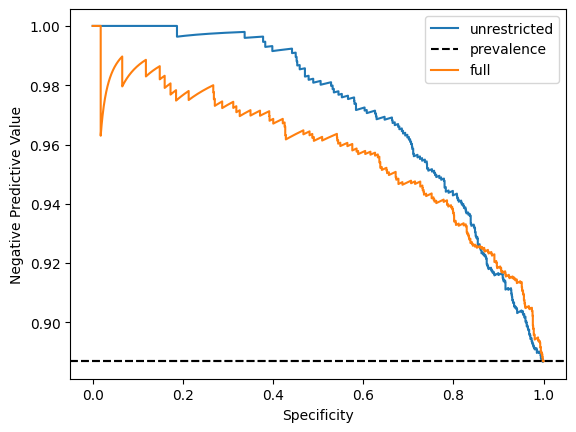

In [26]:
PREDICTIONS_compara_trained_on_unrestricted.plot_npv_tnr_curve()
PREDICTIONS_compara_trained_on_full.plot_npv_tnr_curve()
plt.legend(["unrestricted", "prevalence", "full"])

# Predictions for PubChem

In [ ]:
from rdkit import Chem

import chem_preprocess

In [ ]:
# SDF-Datei laden
sdf_file = "../Lunghini_data/EDdata_merged.sdf"
supplier = Chem.SDMolSupplier(sdf_file)

# Liste für DataFrame-Zeilen
data = []

for mol in supplier:
    if mol is not None:
        props = mol.GetPropsAsDict()
        props["SMILES"] = Chem.MolToSmiles(mol)
        data.append(props)

# DataFrame erstellen
df = pd.DataFrame(data)

In [ ]:
andror_df_pubchem = df[df["DB"] == "PubChem testset"]
andror_df_pubchem = andror_df_pubchem[andror_df_pubchem["Receptor"]=="AR"]
andror_df_pubchem = andror_df_pubchem[andror_df_pubchem["binding_prp"].notnull()]

andror_df_pubchem = andror_df_pubchem.rename(columns={"SMILES": "Structure"})

In [ ]:
andror_df_pubchem = chem_preprocess.standardize_smiles_rdkit(andror_df_pubchem)
andror_df_pubchem = chem_preprocess.create_flat_smiles_rdkit(andror_df_pubchem)

In [ ]:
common_entries = andror_df_pubchem[andror_df_pubchem['flat_smiles'].isin(andror_df_all['flat_smiles'])]

In [ ]:
common_entries

Drop entries that were in HTS data

In [ ]:
andror_df_pubchem = andror_df_pubchem[~andror_df_pubchem['flat_smiles'].isin(andror_df_all['flat_smiles'])]

In [ ]:
# andror_df_pubchem.to_csv("../PubChem_AR.csv")

In [39]:
andror_df_pubchem = pd.read_csv("../PubChem_AR.csv", index_col=0)

In [ ]:
rdkit_descriptors_pubchem = utils.get_rdkit_descriptors(andror_df_pubchem)

Check if any rdkit features are identical

In [ ]:
deduplicated_merged_rdkit_features = pd.concat([rdkit_descriptors.drop_duplicates(), rdkit_descriptors_pubchem.drop_duplicates()])
print(deduplicated_merged_rdkit_features.shape)  # Ausgabe der Form des deduplizierten DataFrames
print(deduplicated_merged_rdkit_features.drop_duplicates().shape)  # Ausgabe der Form des deduplizierten DataFrames

There are no identical rdkit features in Pubchem compared to our HTS

In [36]:
# rdkit_descriptors_pubchem.to_csv("../rdkit_descriptors_pubchem.csv")
rdkit_descriptors_pubchem = pd.read_csv("../rdkit_descriptors_pubchem.csv", index_col=0)

Drop 12 compounds where rdkit features are not complete

In [41]:
rdkit_complete = rdkit_descriptors_pubchem.isna().sum(axis=1) == 0
rdkit_descriptors_pubchem = rdkit_descriptors_pubchem[rdkit_complete]
andror_df_pubchem = andror_df_pubchem[rdkit_complete]

There are 236 compounds where Ipc is > 1e10

In [42]:
rdkit_not_too_high = (rdkit_descriptors_pubchem > 1e10).sum(axis=1) == 0
rdkit_descriptors_pubchem = rdkit_descriptors_pubchem[rdkit_not_too_high]
andror_df_pubchem = andror_df_pubchem[rdkit_not_too_high]

## Predictions

In [44]:
pubchem_predictions_trained_on_unrestricted = HTS_model_unrestricted.predict_proba(
    X=rdkit_descriptors_pubchem,
)

PREDICTIONS_pubchem_trained_on_unrestricted = Predictions(
    y=andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=pubchem_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    y_hat_proba=pubchem_predictions_trained_on_unrestricted,
    )

CV_pubchem_trained_on_unrestricted = CV([{
    "y": andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": pubchem_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    "y_hat_proba": pubchem_predictions_trained_on_unrestricted,}
])

In [46]:
CV_pubchem_trained_on_unrestricted.folds[0].find_npv_halving_tnr()

{'NPV': 0.8835050494746506, 'TNR': 0.8422662588110121}

In [70]:
1 - CV_pubchem_trained_on_unrestricted.prevalence

0.7670100989493012

In [45]:
pubchem_predictions_trained_on_full = HTS_model_full.predict_proba(
    X=rdkit_descriptors_pubchem
)

PREDICTIONS_pubchem_trained_on_full = Predictions(
    y=andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=pubchem_predictions_trained_on_full[:, 1] > 0.5, 
    y_hat_proba=pubchem_predictions_trained_on_full,
    )

CV_compara_trained_on_full = CV([{
    "y": andror_df_pubchem["binding_prp"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": pubchem_predictions_trained_on_full[:, 1] > 0.5, 
    "y_hat_proba": pubchem_predictions_trained_on_full,}
])

In [47]:
CV_compara_trained_on_full.folds[0].find_npv_halving_tnr()

{'NPV': 0.8835050494746506, 'TNR': 0.7584785210799309}

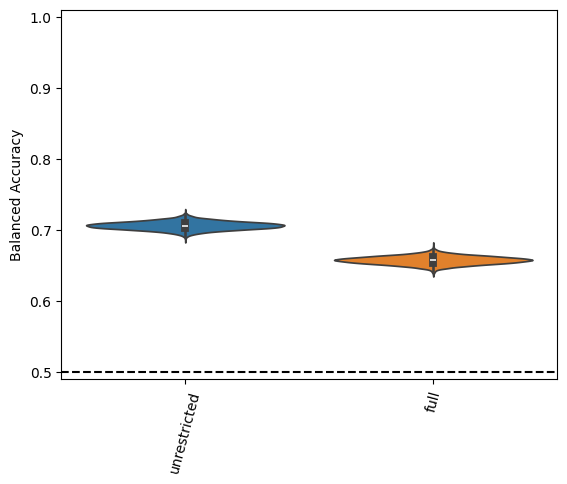

In [51]:
comparison_df = {}

label_threshold = 0.5
sel_metric = "balanced accuracy"
sample_size_posterior = 10000
prior = 1

data_dict = {
    "unrestricted": CV_pubchem_trained_on_unrestricted,
    "full": CV_compara_trained_on_full,
}

for feature_list, cv in data_dict.items():
    metric_estimates = []
    for fold in cv.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        metric_estimates += list(curr_samples)
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df)

sns.violinplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == "MCC":
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == "balanced accuracy":
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")
elif sel_metric == "NPV":
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"Negative Predictive Value (NPV)")
elif sel_metric == "PPV":
    plt.ylabel(f"Positive Predictive Value (PPV)")
elif sel_metric == "TPR":
    plt.ylabel(f"True Positive Rate (TPR)")
elif sel_metric == "TNR":
    plt.ylim(0.4, 1.0)
    plt.ylabel(f"True Negative Rate (TNR)")


comparison_df.to_csv(f"pubchem_bayesian_{sel_metric}_estimates.csv")

In [52]:
comparison_df.describe()

,unrestricted,full
count,10000.000000,10000.000000
mean,0.706361,0.657588
std,0.005566,0.005595
min,0.684287,0.636388
25%,0.702601,0.653801
50%,0.706339,0.657652
75%,0.710060,0.661380
max,0.727686,0.680901


# Plot NPV-specifity curve for CoMPARA and PubChem

In [53]:
from sklearn.metrics import precision_recall_curve

In [ ]:
PREDICTIONS_compara_trained_on_full

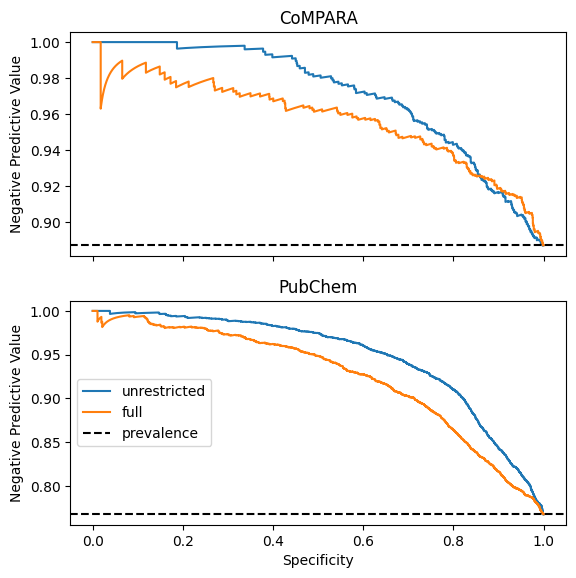

In [68]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6.4, 6.4))

curr_ax = axes[0]
curr_ax.set_title("CoMPARA")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_compara_trained_on_unrestricted.y, PREDICTIONS_compara_trained_on_unrestricted.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="unrestricted")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_compara_trained_on_full.y, PREDICTIONS_compara_trained_on_full.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="full")
curr_ax.axhline(1 - PREDICTIONS_compara_trained_on_full.prevalence, linestyle="--", c="k")
curr_ax.set_ylabel("Negative Predictive Value")

curr_ax = axes[1]
curr_ax.set_title("PubChem")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_pubchem_trained_on_unrestricted.y, PREDICTIONS_pubchem_trained_on_unrestricted.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="unrestricted")
npv, tnr, _ = precision_recall_curve(PREDICTIONS_pubchem_trained_on_full.y, PREDICTIONS_pubchem_trained_on_full.y_hat_proba[:,0], pos_label="inactive")
curr_ax.plot(tnr, npv, label="full")
curr_ax.axhline(1 - PREDICTIONS_pubchem_trained_on_full.prevalence, linestyle="--", c="k")
curr_ax.set_ylabel("Negative Predictive Value")


plt.xlabel('Specificity')
plt.legend(["unrestricted", "full", "prevalence"])

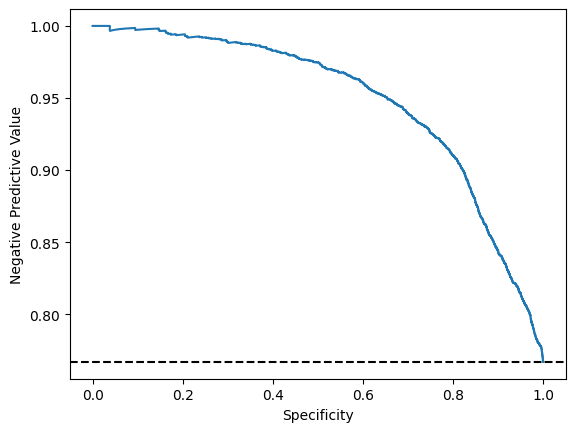

In [55]:
PREDICTIONS_pubchem_trained_on_unrestricted.plot_npv_tnr_curve()

# Comparison to Pubchem

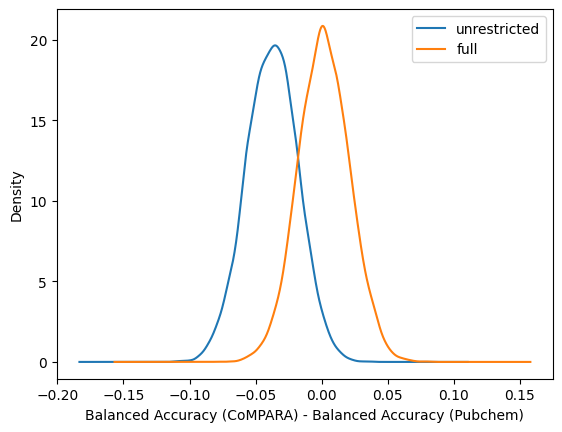

In [38]:
(comparison_df["unrestricted"] - comparison_df_pubchem["unrestricted"]).plot(kind="density", label="unrestricted")
(comparison_df["full"] - comparison_df_pubchem["full"]).plot(kind="density", label="full")
plt.xlabel("Balanced Accuracy (CoMPARA) - Balanced Accuracy (Pubchem)")
plt.legend()

In [50]:
print("unrestricted", (comparison_df["unrestricted"] - comparison_df_pubchem["unrestricted"] > 0).mean())
print("full", (comparison_df["full"] - comparison_df_pubchem["full"] > 0).mean())

unrestricted 0.0259
full 0.5336


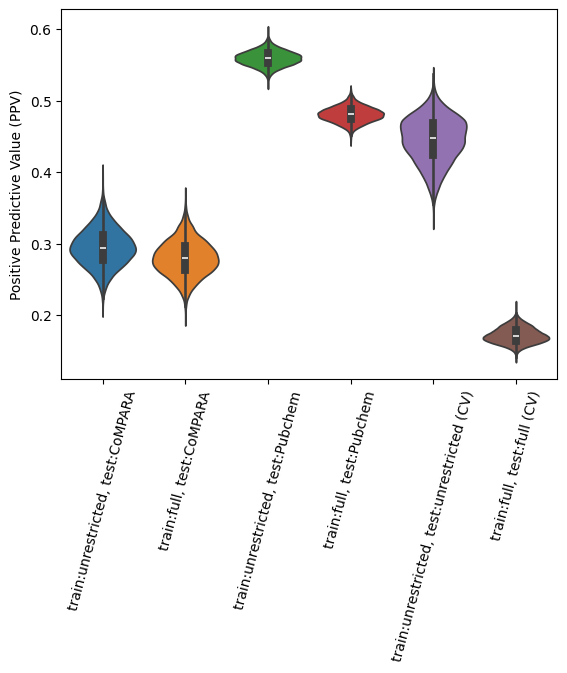

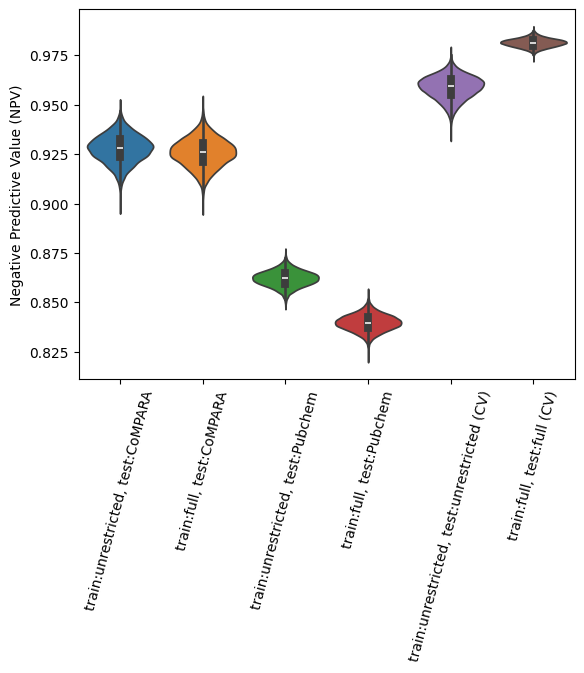

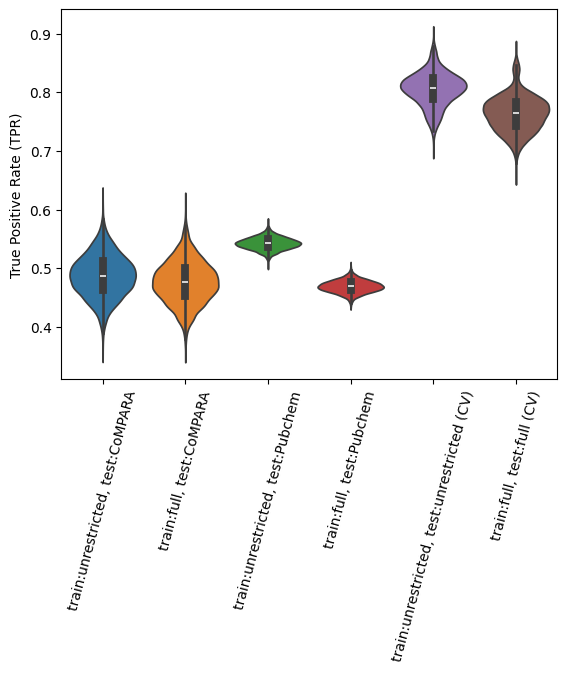

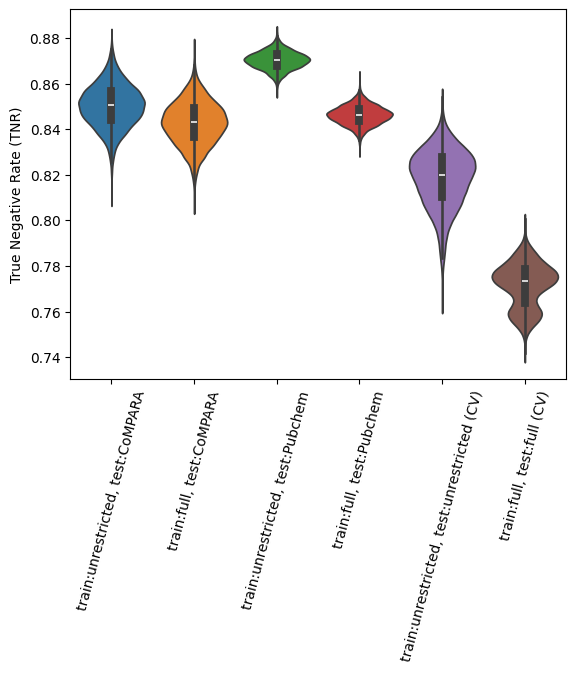

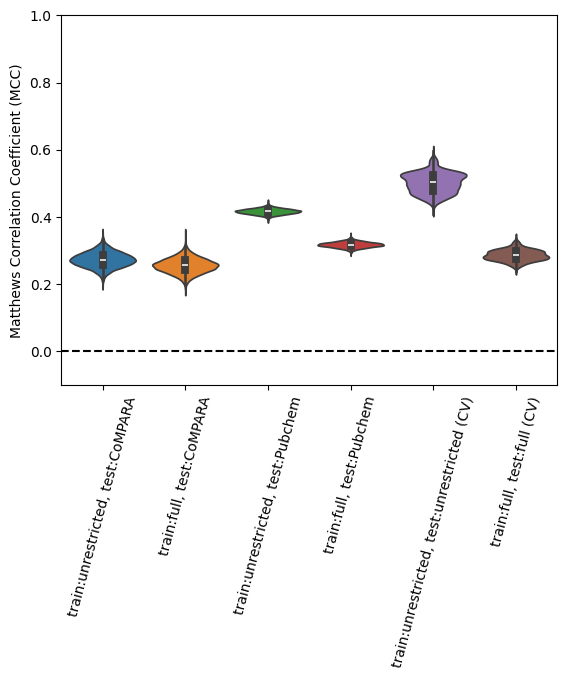

In [80]:
for sel_metric in ["PPV", "NPV", "TPR", "TNR", "MCC"]:

    comparison_df_pubchem = pd.read_csv(f"pubchem_bayesian_{sel_metric}_estimates.csv", index_col=0)
    comparison_df_compara = pd.read_csv(f"compara_bayesian_{sel_metric}_estimates.csv", index_col=0)
    comparison_df_CV = pd.read_csv(f"CV_bayesian_{sel_metric}_estimates.csv", index_col=0)

    comparison_df_both = pd.concat([comparison_df_compara.rename(columns={
        "unrestricted": "train:unrestricted, test:CoMPARA",
        "full": "train:full, test:CoMPARA",    
        }),
        comparison_df_pubchem.rename(columns={
        "unrestricted": "train:unrestricted, test:Pubchem",
        "full": "train:full, test:Pubchem",    
        }),
        comparison_df_CV.rename(columns={
        "unrestricted": "train:unrestricted, test:unrestricted (CV)",
        "full": "train:full, test:full (CV)",    
        }),
    ],
    axis=1)

    sns.violinplot(comparison_df_both)
    # rotate xlabels
    plt.xticks(rotation=75)

    if sel_metric == "MCC":
        plt.ylim(-0.1, 1.)
        plt.axhline(0., color='k', linestyle='--')
        plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
    elif sel_metric == "balanced accuracy":
        plt.ylim(0.49, 1.01)
        plt.axhline(0.5, color='k', linestyle='--')
        plt.ylabel(f"Balanced Accuracy")
    elif sel_metric == "NPV":
        plt.ylabel(f"Negative Predictive Value (NPV)")
    elif sel_metric == "PPV":
        plt.ylabel(f"Positive Predictive Value (PPV)")
    elif sel_metric == "TPR":
        plt.ylabel(f"True Positive Rate (TPR)")
    elif sel_metric == "TNR":
        plt.ylabel(f"True Negative Rate (TNR)")

    plt.show()